<a href="https://colab.research.google.com/github/ssarker21/Introduction-to-Machine-Learning/blob/main/Homework6_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch    1, Train loss 0.6505, Val loss 0.6495, Train acc 0.6316, Val acc 0.6460
Epoch    2, Train loss 0.6475, Val loss 0.6467, Train acc 0.6360, Val acc 0.6460
Epoch    3, Train loss 0.6445, Val loss 0.6439, Train acc 0.6360, Val acc 0.6549
Epoch   50, Train loss 0.5136, Val loss 0.5234, Train acc 0.9079, Val acc 0.9204
Epoch  100, Train loss 0.3871, Val loss 0.4096, Train acc 0.9320, Val acc 0.9381
Epoch  150, Train loss 0.2927, Val loss 0.3261, Train acc 0.9386, Val acc 0.9292
Epoch  200, Train loss 0.2316, Val loss 0.2724, Train acc 0.9452, Val acc 0.9292


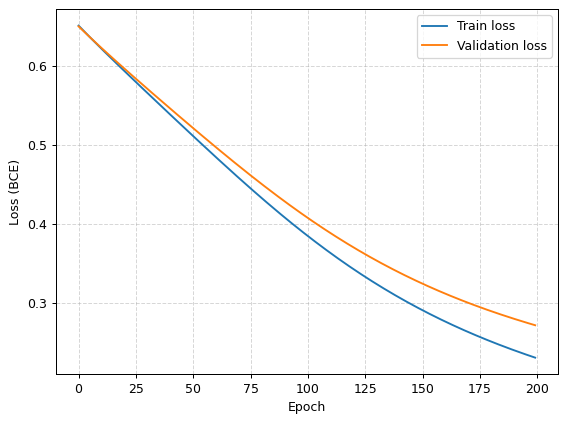

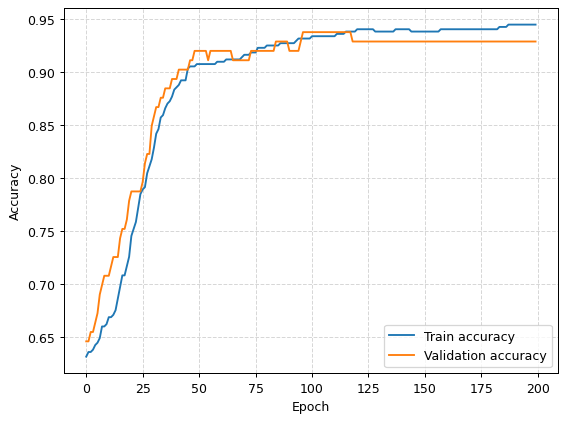


=== Evaluation on Validation Set (Neural Network) ===
Accuracy : 0.9292
Precision: 0.9571
Recall   : 0.9306
F1 score : 0.9437


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt

# ------------------------------------
# 0) Load breast cancer dataset
# ------------------------------------
data = load_breast_cancer()
X_full = torch.tensor(data.data,   dtype=torch.float32)  # shape (N, 30)
y_full = torch.tensor(data.target, dtype=torch.float32).unsqueeze(1)  # (N, 1), labels 0/1

# ------------------------------------
# 1) Train / Validation split (80 / 20) using randperm (like slides)
# ------------------------------------
n_samples = X_full.shape[0]
n_val = int(0.2 * n_samples)

indices   = torch.randperm(n_samples)
train_idx = indices[:-n_val]
val_idx   = indices[-n_val:]

X_train = X_full[train_idx]
y_train = y_full[train_idx]
X_val   = X_full[val_idx]
y_val   = y_full[val_idx]

# ------------------------------------
# 2) Pre-processing: standardize inputs (z-score) using TRAIN stats
# ------------------------------------
x_mean = X_train.mean(dim=0, keepdim=True)
x_std  = X_train.std(dim=0, keepdim=True) + 1e-8

X_train_std = (X_train - x_mean) / x_std
X_val_std   = (X_val   - x_mean) / x_std

# ------------------------------------
# 3) Fully-connected neural network (multiple hidden layers)
# ------------------------------------
n_features = X_train_std.shape[1]

seq_model = nn.Sequential(
    nn.Linear(n_features, 32),  # hidden layer 1
    nn.Tanh(),
    nn.Linear(32, 16),          # hidden layer 2
    nn.Tanh(),
    nn.Linear(16, 1)            # output (1 logit for binary classification)
)

# ------------------------------------
# 4) Loss and optimizer
# ------------------------------------
loss_fn   = nn.BCEWithLogitsLoss()                # same as diabetes NN
optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)

# ------------------------------------
# 5) Training loop (same style as diabetes code)
#    -> records loss and accuracy
# ------------------------------------
def training_loop(n_epochs, optimizer, model, loss_fn,
                  X_train, X_val, y_train, y_val):
    train_losses = []
    val_losses   = []
    train_accs   = []
    val_accs     = []

    for epoch in range(1, n_epochs + 1):
        # ----- forward on training data -----
        y_pred_train = model(X_train)
        train_loss   = loss_fn(y_pred_train, y_train)

        # ----- forward on validation data (no backward) -----
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss   = loss_fn(y_pred_val, y_val)

        # ----- backward + update using ONLY training loss -----
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # ----- compute accuracies -----
        with torch.no_grad():
            train_probs = torch.sigmoid(y_pred_train)
            val_probs   = torch.sigmoid(y_pred_val)

            train_preds = (train_probs >= 0.5).float()
            val_preds   = (val_probs   >= 0.5).float()

            train_acc = (train_preds == y_train).float().mean()
            val_acc   = (val_preds   == y_val).float().mean()

        train_losses.append(float(train_loss.detach()))
        val_losses.append(float(val_loss.detach()))
        train_accs.append(float(train_acc))
        val_accs.append(float(val_acc))

        if epoch <= 3 or epoch % 50 == 0:
            print(
                f"Epoch {epoch:4d}, "
                f"Train loss {train_loss.item():.4f}, "
                f"Val loss {val_loss.item():.4f}, "
                f"Train acc {train_acc.item():.4f}, "
                f"Val acc {val_acc.item():.4f}"
            )

    return train_losses, val_losses, train_accs, val_accs

# ------------------------------------
# 6) Run training (e.g., 200 epochs)
# ------------------------------------
n_epochs = 200
train_hist, val_hist, train_acc_hist, val_acc_hist = training_loop(
    n_epochs    = n_epochs,
    optimizer   = optimizer,
    model       = seq_model,
    loss_fn     = loss_fn,
    X_train     = X_train_std,
    X_val       = X_val_std,
    y_train     = y_train,
    y_val       = y_val
)

# ------------------------------------
# 7) Plot training vs validation loss
# ------------------------------------
fig = plt.figure(dpi=90)
plt.xlabel("Epoch")
plt.ylabel("Loss (BCE)")
plt.plot(train_hist, label="Train loss")
plt.plot(val_hist,   label="Validation loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------
# 8) Plot training vs validation accuracy
# ------------------------------------
fig = plt.figure(dpi=90)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc_hist, label="Train accuracy")
plt.plot(val_acc_hist,   label="Validation accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------
# 9) Final metrics: Accuracy, Precision, Recall, F1 (Validation set)
# ------------------------------------
with torch.no_grad():
    logits_val = seq_model(X_val_std)
    probs_val  = torch.sigmoid(logits_val)
    preds_val  = (probs_val >= 0.5).float()

y_true = y_val.view(-1)
y_pred = preds_val.view(-1)

tp = ((y_pred == 1) & (y_true == 1)).sum().item()
tn = ((y_pred == 0) & (y_true == 0)).sum().item()
fp = ((y_pred == 1) & (y_true == 0)).sum().item()
fn = ((y_pred == 0) & (y_true == 1)).sum().item()

eps = 1e-8

accuracy  = (tp + tn) / (tp + tn + fp + fn + eps)
precision = tp / (tp + fp + eps)
recall    = tp / (tp + fn + eps)
f1        = 2 * precision * recall / (precision + recall + eps)

print("\n=== Evaluation on Validation Set (Neural Network) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 score : {f1:.4f}")


In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ------------------------------------
# 0) Load breast cancer dataset
# ------------------------------------
data = load_breast_cancer()
X = data.data    # shape (N, 30)
y = data.target  # 0 = malignant, 1 = benign

# ------------------------------------
# 1) Train / Validation split (80 / 20)
# ------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,   # for reproducibility
    stratify=y        # keep class balance
)

# ------------------------------------
# 2) Standardize features using TRAIN stats
# ------------------------------------
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std   = scaler.transform(X_val)

# ------------------------------------
# Helper: compute and print metrics
# ------------------------------------
def compute_metrics(name, y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {name} (Validation set) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}")

# ------------------------------------
# 3) Logistic Regression
# ------------------------------------
log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000
)
log_reg.fit(X_train_std, y_train)
y_val_pred_log = log_reg.predict(X_val_std)
compute_metrics("Logistic Regression", y_val, y_val_pred_log)

# ------------------------------------
# 4) Support Vector Machine (SVM, RBF kernel)
# ------------------------------------
svm_clf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale"
)
svm_clf.fit(X_train_std, y_train)
y_val_pred_svm = svm_clf.predict(X_val_std)
compute_metrics("SVM (RBF kernel)", y_val, y_val_pred_svm)



=== Logistic Regression (Validation set) ===
Accuracy : 0.9825
Precision: 0.9730
Recall   : 1.0000
F1 score : 0.9863

=== SVM (RBF kernel) (Validation set) ===
Accuracy : 0.9649
Precision: 0.9722
Recall   : 0.9722
F1 score : 0.9722
